In [1]:
# Hack to import outside folder 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
#from LSTM import LSTM
import pandas as pd
import torch
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out)

        return out

In [2]:
# Print found devices
devices = [d for d in range(torch.cuda.device_count())] 
device_names  = [torch.cuda.get_device_name(d) for d in devices]
print(device_names)

# Cuda device to use .to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load the data
data = pd.read_csv('test.csv')

# Convert the string representation of lists to actual lists
data['feature'] = data['feature'].apply(eval)
data['label'] = data['label'].apply(eval)


[]
cpu


In [34]:
sequence_length = 5
batch_size = 5

midi_max = 127
# Normalize the values of the features
data['feature_norm'] =  [[x / 127.0 for x in sequence] for sequence in data['feature']]
data['label_norm'] = [[x / 127.0 for x in sequence] for sequence in data['label']]

# Denormalize the values of the features


# Convert the features and labels to PyTorch tensors
feature_tensor = torch.tensor(data['feature_norm']).unsqueeze(-1)
label_tensor = torch.tensor(data['label_norm']).unsqueeze(-1)

print('Input sequences tensor size:', feature_tensor.size())
print('Target sequences tensor size:', label_tensor.size())

# Split data into training and test sets
input_sequences_train, input_sequences_test, target_sequences_train, target_sequences_test = train_test_split(feature_tensor, label_tensor, test_size=0.2, random_state=42)

print('Training set size:', input_sequences_train.size(), target_sequences_train.size())
print('Test set size:', input_sequences_test.size(), target_sequences_test.size())


# Initialize the LSTM model
model = LSTM(input_size=1, hidden_size=64, output_size=1, num_layers=3)
# Move the model to the device
model.to(device)
print(model)

# Move data to the same device as model
input_sequences_train = input_sequences_train.to(device)
target_sequences_train = target_sequences_train.to(device)
input_sequences_test = input_sequences_test.to(device)
target_sequences_test = target_sequences_test.to(device)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
epochs = 2000

# Train the model
for epoch in range(epochs):
    
    # Forward pass
    outputs = model(input_sequences_train)
    loss = criterion(outputs, target_sequences_train)

     # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))



Input sequences tensor size: torch.Size([1110, 5, 1])
Target sequences tensor size: torch.Size([1110, 5, 1])
Training set size: torch.Size([888, 5, 1]) torch.Size([888, 5, 1])
Test set size: torch.Size([222, 5, 1]) torch.Size([222, 5, 1])
LSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [1/2000], Loss: 0.2040
Epoch [2/2000], Loss: 0.1913
Epoch [3/2000], Loss: 0.1791
Epoch [4/2000], Loss: 0.1674
Epoch [5/2000], Loss: 0.1559
Epoch [6/2000], Loss: 0.1448
Epoch [7/2000], Loss: 0.1338
Epoch [8/2000], Loss: 0.1230
Epoch [9/2000], Loss: 0.1123
Epoch [10/2000], Loss: 0.1017
Epoch [11/2000], Loss: 0.0913
Epoch [12/2000], Loss: 0.0810
Epoch [13/2000], Loss: 0.0711
Epoch [14/2000], Loss: 0.0618
Epoch [15/2000], Loss: 0.0535
Epoch [16/2000], Loss: 0.0467
Epoch [17/2000], Loss: 0.0422
Epoch [18/2000], Loss: 0.0407
Epoch [19/2000], Loss: 0.0421
Epoch [20/2000], Loss: 0.0446
Epoch [21/2000], Loss: 0.0460
Epoch [22/2000], Los

In [35]:
def test_model(model, input_sequences, target_sequences):
    # Set the model to evaluation mode
    model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = model(input_sequences)

    # Calculate the Mean Absolute Percentage Error (MAPE)
    mape = torch.mean(torch.abs((target_sequences - outputs) / target_sequences)) * 100

    print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(mape.item()))

# Test the model
test_model(model, input_sequences_test, target_sequences_test)


Mean Absolute Percentage Error (MAPE): 6.68%


Mean Absolute Percentage Error (MAPE): 6.68%


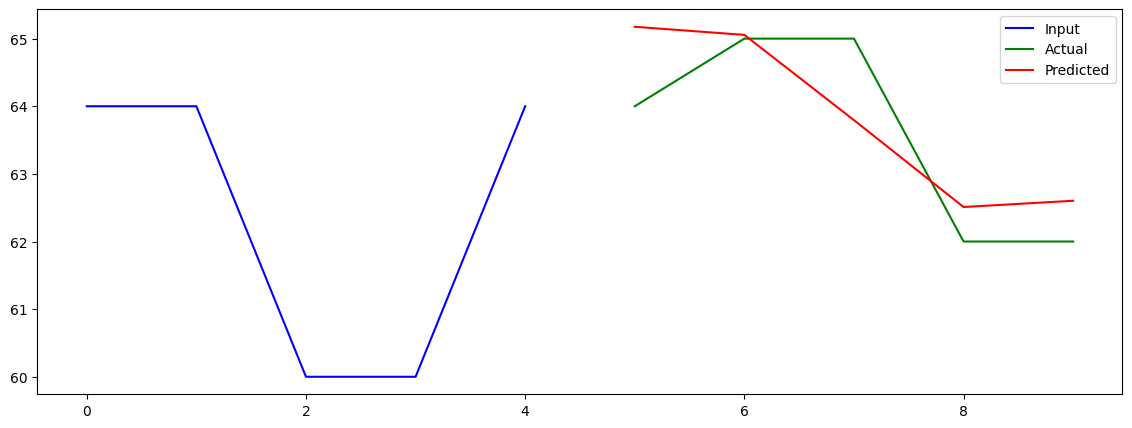

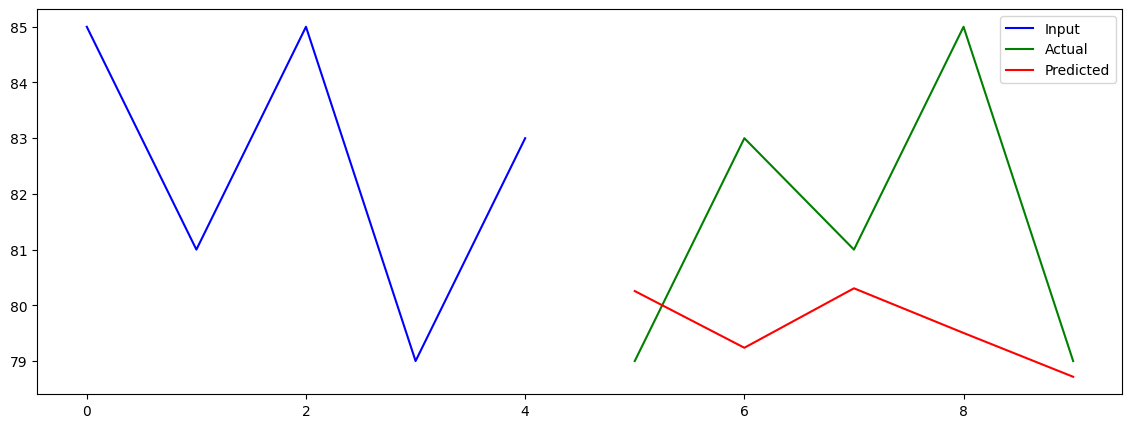

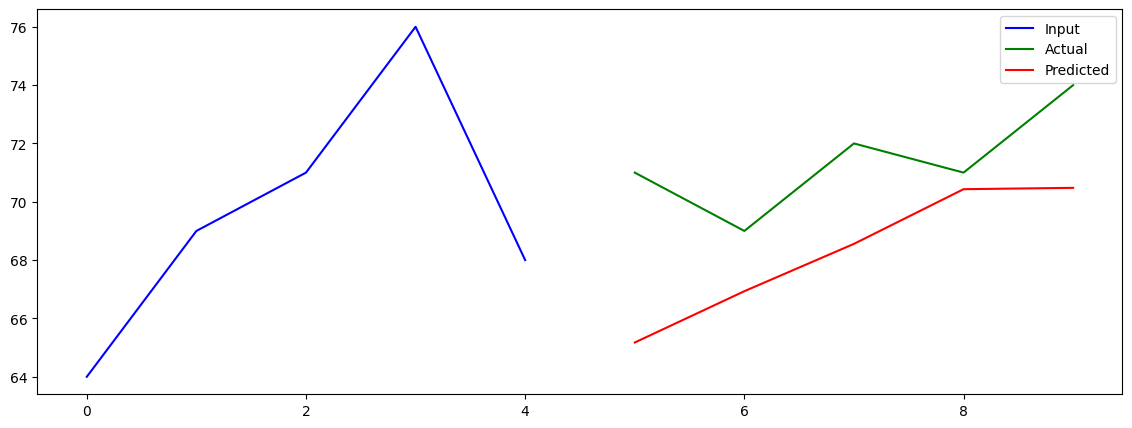

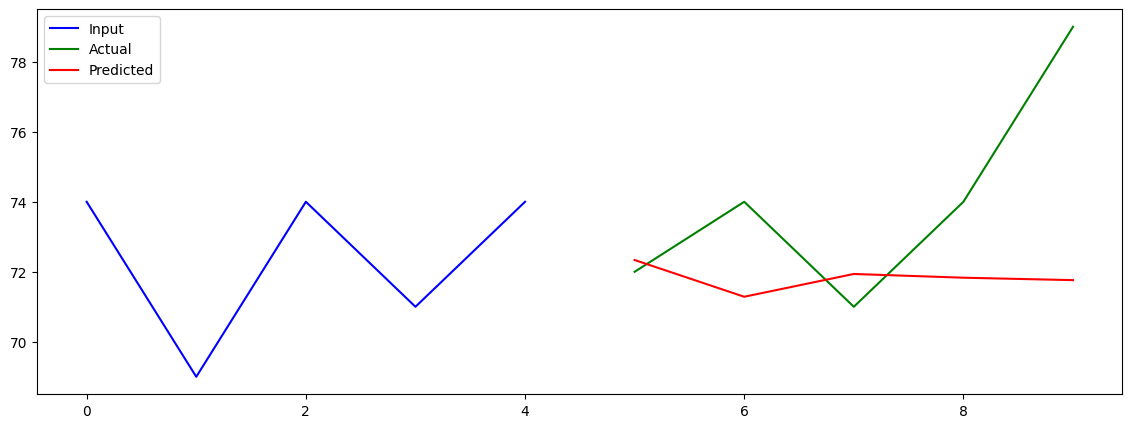

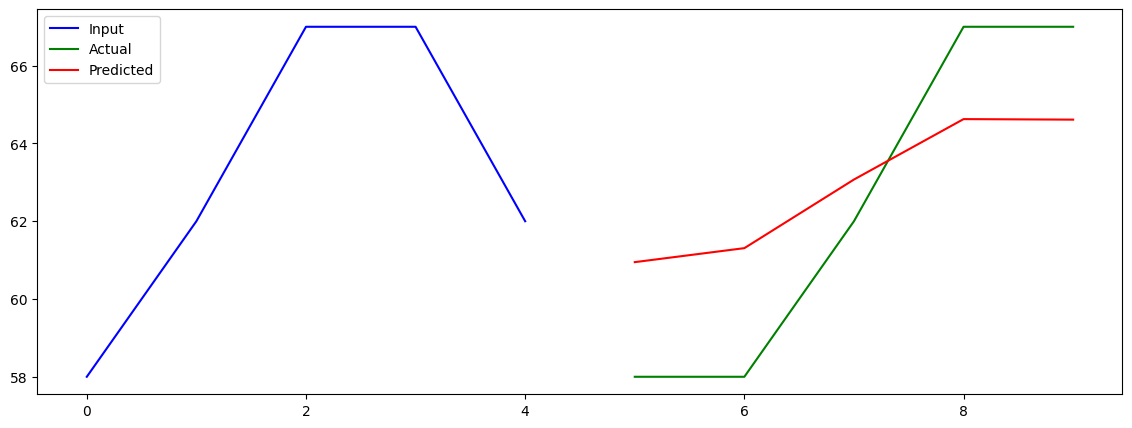

In [45]:
import matplotlib.pyplot as plt

def evaluate_and_plot(model, input_sequences, target_sequences):
    # Set the model to evaluation mode
    model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = model(input_sequences)

    # Calculate the Mean Absolute Percentage Error (MAPE)
    mape = torch.mean(torch.abs((target_sequences - outputs) / target_sequences)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.2f}%'.format(mape.item()))

    # Plot the predicted and actual values
    y_pred = outputs.cpu().numpy()
    y = target_sequences.cpu().numpy()
    # y_pred and y are in the size (num,batch,dim) so we need to reshape them to (num*batch,dim)
    y_pred = y_pred.reshape(y_pred.shape[0] * y_pred.shape[1], y_pred.shape[2])
    y = y.reshape(y.shape[0] * y.shape[1], y.shape[2])

    x = input_sequences.cpu().numpy()
    x = x.reshape(x.shape[0] * x.shape[1], x.shape[2])

    # De-normalize the values
    y_pred = y_pred * midi_max
    y = y * midi_max
    x = x * midi_max

    # Plot the first 5 sequences where the input is the first 5 values of the sequence y_pred and y is the next 5 in two different colors, green for actual and red for predicted
    for i in range(5):
        plt.figure(figsize=(14, 5))
        # The first 5 values are the input
        plt.plot(np.arange(0, sequence_length), x[i * sequence_length:(i + 1) * sequence_length], 'b', label='Input')
        # The next 5 values are the actual values
        plt.plot(np.arange(sequence_length, sequence_length * 2), y[i * sequence_length:(i + 1) * sequence_length], 'g', label='Actual')
        # The next 5 values are the predicted values
        plt.plot(np.arange(sequence_length, sequence_length * 2), y_pred[i * sequence_length:(i + 1) * sequence_length], 'r', label='Predicted')

        plt.legend()
        plt.show()

    return x,y,y_pred

# Evaluate the model and plot the results
x,y,y_pred = evaluate_and_plot(model, input_sequences_test, target_sequences_test)


In [54]:

import mido
from mido import Message, MidiFile, MidiTrack

mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

# Create a MIDI file that consists of the first 5 notes of the input + the 5 predicted notes
# The speed should be around 0.5 seconds per note
# Create 5 files like this and listen to them to see how the model performs
time = 250
for i in range(5):
    for j in range(sequence_length):
        # Put the 5 input notes using x
        track.append(Message('note_on', note=int(x[i * sequence_length + j]), velocity=127, time=time))
        track.append(Message('note_off', note=int(x[i * sequence_length + j]), velocity=127, time=time))
    for j in range(sequence_length):
        # put the 5 predicted notes using y_pred
        track.append(Message('note_on', note=int(y_pred[i * sequence_length + j]), velocity=127, time=time))
        track.append(Message('note_off', note=int(y_pred[i * sequence_length + j]), velocity=127, time=time))

    mid.save('lstm_{}.mid'.format(i))


C:\Users\NIOA\AppData\Local\Temp\ipykernel_27692\2791654234.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  track.append(Message('note_on', note=int(x[i * sequence_length + j]), velocity=127, time=time))
C:\Users\NIOA\AppData\Local\Temp\ipykernel_27692\2791654234.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  track.append(Message('note_off', note=int(x[i * sequence_length + j]), velocity=127, time=time))
C:\Users\NIOA\AppData\Local\Temp\ipykernel_27692\2791654234.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your arra

In [56]:
# Play a MIDI file
import pygame

# Initialize the mixer module
pygame.mixer.init()

# Load the MIDI file
pygame.mixer.music.load('lstm_1.mid')

# Play the loaded MIDI file
pygame.mixer.music.play()

In [ ]:
# Assuming 'model' is your trained model
print(model.state_dict().keys())
torch.save(model.state_dict(), 'LSTMTest.pth')